In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
import torchvision.datasets as datasets
from art.attacks.evasion import BasicIterativeMethod, CarliniL2Method, FastGradientMethod
from art.estimators.classification import PyTorchClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, ParameterGrid, train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from lid import LidDetector, eval_lid, merge_adv_data, train_lid
from util import get_correct_examples, get_roc, get_shape, merge_and_generate_labels

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

n_threads = os.cpu_count()
print('CPU threads: {}'.format(n_threads))

Device: cuda
CPU threads: 24


In [5]:
PATH_DATA = os.path.join('..', 'data')
BATCH_SIZE = 128
EPOCHS = 5

In [6]:
# Fetch dataset
transforms = tv.transforms.Compose([tv.transforms.ToTensor()])
dataset_train = datasets.MNIST(PATH_DATA, train=True, download=True, transform=transforms)
dataset_test = datasets.MNIST(PATH_DATA, train=False, download=True, transform=transforms)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# Create Neural Network model
model = nn.Sequential(
    nn.Conv2d(1, 32, 3, 1),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(9216, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.LogSoftmax(dim=1)
)
model.to(device)
print('Number of layers: {}'.format(len(list(model.children()))))

Number of layers: 10


In [8]:
def train(model, loader, loss, optimizer):
    model.train()
    total_loss = 0.
    corrects = 0.
    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        batch_size = x.size(0)
        
        optimizer.zero_grad()
        outputs = model(x)
        l = loss(outputs, y)
        l.backward()
        optimizer.step()

        # for display
        total_loss += l.item() * batch_size
        preds = outputs.max(1, keepdim=True)[1]
        corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [9]:
def validate(model, loader, loss):
    model.eval()
    total_loss = 0.
    corrects = 0.
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            batch_size = x.size(0)
            outputs = model(x)
            l = loss(outputs, y)
            total_loss += l.item() * batch_size
            preds = outputs.max(1, keepdim=True)[1]
            corrects += preds.eq(y.view_as(preds)).sum().item()
    
    n = len(loader.dataset)
    total_loss = total_loss / n
    accuracy = corrects / n
    return total_loss, accuracy

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss=nn.NLLLoss()

In [11]:
since = time.time()
for epoch in range(EPOCHS):
    start = time.time()
    tr_loss, tr_acc = train(model, dataloader_train, loss, optimizer)
    va_loss, va_acc = validate(model, dataloader_test, loss)
    
    time_elapsed = time.time() - start
    print(('[{:2d}] {:.0f}m {:.1f}s Train Loss: {:.4f} Accuracy: {:.4f}%, ' +
        'Test Loss: {:.4f} Accuracy: {:.4f}%').format(
            epoch+1, time_elapsed // 60, time_elapsed % 60,
            tr_loss, tr_acc*100.,
            va_loss, va_acc*100.))
    
time_elapsed = time.time() - since
print('Total run time: {:.0f}m {:.1f}s'.format(
    time_elapsed // 60,
    time_elapsed % 60))

[ 1] 0m 4.4s Train Loss: 0.3982 Accuracy: 88.5717%, Test Loss: 0.1580 Accuracy: 94.9400%
[ 2] 0m 4.5s Train Loss: 0.1216 Accuracy: 96.2017%, Test Loss: 0.0869 Accuracy: 97.3600%
[ 3] 0m 4.6s Train Loss: 0.0762 Accuracy: 97.6200%, Test Loss: 0.0565 Accuracy: 98.2900%
[ 4] 0m 4.5s Train Loss: 0.0523 Accuracy: 98.4167%, Test Loss: 0.0590 Accuracy: 98.1500%
[ 5] 0m 4.4s Train Loss: 0.0389 Accuracy: 98.7933%, Test Loss: 0.0479 Accuracy: 98.4600%
Total run time: 0m 22.4s


In [12]:
print('Training set: {}'.format(len(dataset_train)))
tensor_train_X, tensor_train_y = get_correct_examples(model, dataset_train, device=device, return_tensor=True)
dataset_train_perfect = TensorDataset(tensor_train_X, tensor_train_y)
dataloader_train_perfect = DataLoader(dataset_train_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_train_perfect, loss)
print('Accuracy on {} filtered training examples: {:.4f}%'.format(len(dataloader_train_perfect.dataset), acc*100))

print('Test set: {}'.format(len(dataset_test)))
tensor_test_X, tensor_test_y = get_correct_examples(model, dataset_test, device=device, return_tensor=True)
dataset_test_perfect = TensorDataset(tensor_test_X, tensor_test_y)
dataloader_test_perfect = DataLoader(dataset_test_perfect, batch_size=512, shuffle=True)
_, acc = validate(model, dataloader_test_perfect, loss)
print('Accuracy on {} filtered test examples: {:.4f}%'.format(len(dataloader_test_perfect.dataset), acc*100))

Training set: 60000
Accuracy on 59437 filtered training examples: 100.0000%
Test set: 10000
Accuracy on 9846 filtered test examples: 100.0000%


In [13]:
N_ADV = 2000

In [14]:
classifier = PyTorchClassifier(
    model=model, 
    loss=loss, 
    input_shape=(1, 28, 28), 
    optimizer=optimizer,
    nb_classes=10,
    clip_values=(0.0, 1.0),
    device_type=device
)

attack = FastGradientMethod(estimator=classifier, eps=0.2)
# attack = BasicIterativeMethod(estimator=classifier, eps=0.2)

In [15]:
# Prepare dataset for adversarial examples
n = len(dataset_test_perfect)
indices = torch.randperm(n)[:N_ADV]

pt_subset_X = tensor_test_X[indices]  # PyTorch Tensor
pt_subset_y = tensor_test_y[indices]

subset_X = pt_subset_X.cpu().detach().numpy()
subset_y = pt_subset_y.cpu().detach().numpy()

In [16]:
# Create adversarial examples
subset_pred = np.argmax(classifier.predict(subset_X), axis=1)
accuracy = np.sum(subset_pred == subset_y) / float(len(subset_pred))
print("Model accuracy on clean examples: {:.4f}%".format(accuracy * 100))

# Generate adversarial examples
subset_adv = attack.generate(x=subset_X)
subset_pred = np.argmax(classifier.predict(subset_adv), axis=1)

accuracy = np.sum(subset_pred == subset_y) / float(len(subset_pred))
print("Model accuracy on adversarial examples: {:.4f}%".format(accuracy * 100))

Model accuracy on clean examples: 100.0000%
Model accuracy on adversarial examples: 42.4000%


In [17]:
X_lid_train = subset_X[-1000:]
adv_lid_train = subset_adv[-1000:]

# Average L2 distance
l2_adv = np.mean([np.linalg.norm(dif) for dif in (X_lid_train - adv_lid_train)])
print('L2 distance between adversairal examples and clean data: {:.4f}'.format(l2_adv))

# Create noisy data
std = l2_adv / 20
noise = np.random.normal(0, scale=std, size=X_lid_train.shape)
noisy_lid_train = np.minimum(np.maximum(X_lid_train + noise, 0.0), 1.0)

l2_noise = np.mean([np.linalg.norm(dif) for dif in (X_lid_train - noisy_lid_train)])
print('L2 distance between noisy data and clean data: {:.4f}'.format(l2_noise))

L2 distance between adversairal examples and clean data: 4.1756
L2 distance between noisy data and clean data: 4.2481


In [18]:
# Compute LID characteristics
K_LID = 20
BATCH_SIZE_LID = 100

## Train LID detector (functional)

In [19]:
# characteristics, labels = train_lid(model, X_lid_train, noisy_lid_train, adv_lid_train, 
#                                     k=K_LID, batch_size=BATCH_SIZE_LID, device=device)
# scaler = MinMaxScaler().fit(characteristics)
# characteristics = scaler.transform(characteristics)

In [20]:
# lid_train, lid_test, lid_label_train, lid_label_test = train_test_split(characteristics, labels, test_size=0.2, shuffle=True)
# print("Train data size: ", lid_train.shape)
# print("Test data size: ", lid_test.shape)

In [21]:
# reg_model = LogisticRegressionCV(cv=5, n_jobs=-1).fit(lid_train, lid_label_train)

# lid_label_prob = reg_model.predict_proba(lid_test)[:, 1]
# lid_label_pred = reg_model.predict(lid_test)

In [22]:
# _, _, auc_score, _ = get_roc(lid_label_test, lid_label_prob, show_plot=True)
# precision = precision_score(lid_label_test, lid_label_pred)
# recall = recall_score(lid_label_test, lid_label_pred)
# acc = accuracy_score(lid_label_test, lid_label_pred)

# print('Detector ROC-AUC score: {:0.4f}, accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(
#     auc_score, acc, precision, recall))

In [23]:
# print(len(np.where(lid_label_pred==1)[0]), len(np.where(lid_label_pred==0)[0]))

## Test LID detector (functional)

In [24]:
X_lid_train = subset_X[-1000:]

# Create test set
X_test, label_test = merge_and_generate_labels(subset_adv[:1000], subset_X[:1000], flatten=False)
y_test = np.concatenate((subset_y[:1000], subset_y[:1000]))

# Shuffle examples
indices = np.random.permutation(X_test.shape[0])
X_test = X_test[indices]
y_test = y_test[indices]
label_test = label_test[indices]

In [25]:
pred = np.argmax(classifier.predict(X_test), axis=1).astype(np.long)
accuracy = np.sum(pred == y_test) / float(len(X_test))
print("Model accuracy on test examples: {:.4f}%".format(accuracy * 100))

Model accuracy on test examples: 70.8500%


In [26]:
# Using a small subset for faster testing
# n_small = 100
# X_test = X_test[:n_small]
# y_test = y_test[:n_small]
# label_test = label_test[:n_small]

In [27]:
# lid_test = eval_lid(model, X_lid_train, X_test, k=K_LID, batch_size=BATCH_SIZE_LID, device=device)

In [28]:
# print(X_lid_train.shape)
# print(X_test.shape)

In [29]:
# lid_test = scaler.transform(lid_test)

# test_label_prob = reg_model.predict_proba(lid_test)[:, 1]
# test_label_pred = reg_model.predict(lid_test)

# _, _, auc_score, _ = get_roc(label_test, test_label_prob, show_plot=True)
# precision = precision_score(label_test, test_label_pred)
# recall = recall_score(label_test, test_label_pred)
# acc = accuracy_score(label_test, test_label_pred)

# print('Detector ROC-AUC score: {:0.4f}, accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(
#     auc_score, acc, precision, recall))

In [30]:
# print(len(np.where(label_test==1)[0]), len(np.where(label_test==0)[0]))
# print(len(np.where(test_label_pred==1)[0]), len(np.where(test_label_pred==0)[0]))

## Train LID Detector (class object)

In [31]:
my_train_X, my_train_y = merge_adv_data(X_lid_train, noisy_lid_train, adv_lid_train)
print(X_lid_train.shape)
print(my_train_X.shape)

(1000, 1, 28, 28)
(1000, 3, 1, 28, 28)


In [32]:
detector = LidDetector(model=model, k=K_LID, batch_size=BATCH_SIZE_LID, device=device)
detector.fit(my_train_X, my_train_y, disable_progress_bar=False)

100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


LidDetector(device=device(type='cuda'),
            model=Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=9216, out_features=200, bias=True)
  (7): ReLU()
  (8): Linear(in_features=200, out_features=10, bias=True)
  (9): LogSoftmax(dim=1)
))

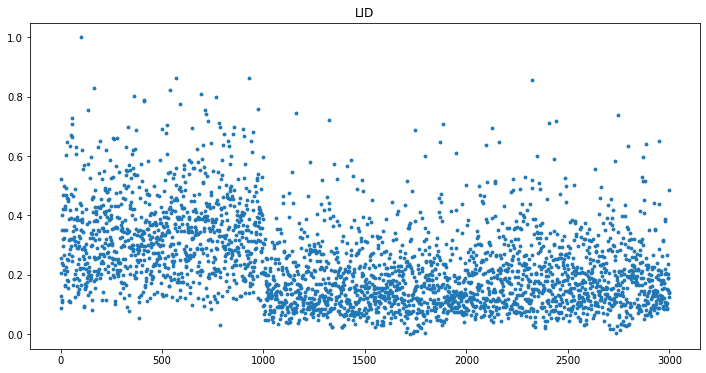

In [33]:
plt.figure(figsize=(12, 6))
plt.scatter(np.arange(len(detector.characteristics_)), detector.characteristics_[:,-1], s=8)
plt.title('LID')
plt.show()

## Testing LID detector (class object)

In [34]:
# pred = detector.predict(X_test)

# print(len(np.where(pred==1)[0]), len(np.where(pred==0)[0]))
# print(len(np.where(label_test==1)[0]), len(np.where(label_test==0)[0]))

# accuracy = np.sum(pred == label_test) / float(len(label_test))
# print("Model accuracy on clean examples: {:.4f}%".format(accuracy * 100))

In [35]:
# detector.predict_proba(X_test[:5])

In [36]:
# detector.score(X_test[:100], label_test[:100])

In [37]:
# prob = detector.predict_proba(X_test)
# pred = np.argmax(prob, axis=1)

# fpr, tpr, auc_score, thresholds = get_roc(label_test, prob[:, 1], show_plot=True)
# precision = precision_score(label_test, pred)
# recall = recall_score(label_test, pred)
# acc = accuracy_score(label_test, pred)

# print('Detector ROC-AUC score: {:0.4f}, accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}'.format(
#     auc_score, acc, precision, recall))

## Grid search hyper-parameter values for LID

In [38]:
param_grid = {'model': [model], 'k': list(range(K_LID-5, K_LID+6)), 
              'batch_size': [BATCH_SIZE_LID], 'device': [device]}
grid_search = GridSearchCV(LidDetector(), param_grid, cv=4, verbose=1)

In [39]:
grid_search.fit(my_train_X, my_train_y)

Fitting 4 folds for each of 11 candidates, totalling 44 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed: 10.4min finished


GridSearchCV(cv=4, estimator=LidDetector(),
             param_grid={'batch_size': [100], 'device': [device(type='cuda')],
                         'k': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
                         'model': [Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=9216, out_features=200, bias=True)
  (7): ReLU()
  (8): Linear(in_features=200, out_features=10, bias=True)
  (9): LogSoftmax(dim=1)
)]},
             verbose=1)

In [40]:
grid_search.best_params_

{'batch_size': 100,
 'device': device(type='cuda'),
 'k': 15,
 'model': Sequential(
   (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
   (1): ReLU()
   (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
   (3): ReLU()
   (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (5): Flatten(start_dim=1, end_dim=-1)
   (6): Linear(in_features=9216, out_features=200, bias=True)
   (7): ReLU()
   (8): Linear(in_features=200, out_features=10, bias=True)
   (9): LogSoftmax(dim=1)
 )}

In [41]:
grid_search.best_score_

0.847428